## Going through all single runs

In [28]:
#Going through metrics
import numbers
import glob
import os
import csv

if True:
    combined_data_ = {}
    target_kernels = []
    
metric_targets = []
all_sig_metrics = []
#bench_targets = [ "gaussianP" , "gaussianV", "gemm", "stream", "kmeans_cudaV", "kmeans_cudaP" ]
#for filen_ in glob.glob("/home/yzamora/power/nvidia_gpus/all_apps/mixed_results/*.csv"):
#for filen_ in glob.glob("/home/yzamora/power/nvidia_gpus/all_apps/gaussian_results/*.csv"):
for filen_ in glob.glob("/gpfs/jlse-fs0/users/yzamora/v100_testing/v100_p100_results/*.csv"):
    filen = os.path.basename(filen_)
    #print (filen)
    filen_split = filen.split('.')[0].split('_')
    bench_name = filen_split[0]
    size = filen_split[1]
    
    #Run if applications contain kmeans in name
    if False: 
        if 'kmeans' in filen_split[0]:
            size = (filen.split('.')[0].split('N')[1])
        else:
            size = filen_split[1].split('N')[1]
    
    #metric_name = filen_split[1]
    #print(filen_split[0][-1]) #gives you p or v
    #size_str = filen_split[1].split('N')[1]
    
    #if not (metric_name in metric_targets): continue
    #if not (bench_name in bench_targets): continue
    
    key_root = bench_name
    #print(key_root)
    levels = ["Idle", "Low","High", "Max"]
    bw_units = ["GB", "MB", "KB" ,"0B"]
    # Now open the file and look for the data
    with open(filen_ ,'r') as file_handle:
        #print (file_handle)
        data_found = False
        ncols = 1
        fdata = csv.reader(file_handle)
        index_lookup = {}
        #print(filen_)
        for line_split in fdata:
            #print (line_split)
            lsplt = (len(line_split) > 0)
      
            if data_found:
                #print("data found")
                if lsplt and len(line_split) == ncols:
                    #percent - strip off end
                    # Get metric name here
                    #mname_index = index_lookup['Metric Name']
                    #metric_name = line_split[ mname_index ]
                    #if not (metric_name in metric_targets): continue
                    
                    # Read in desired value for the current metric
                    target_index = index_lookup['Avg']; value = 0
                    metric_name = line_split[index_lookup['Metric Name']]
                    #print (line_split[target_index].isdecimal())
                    if line_split[target_index].isdecimal():
                        if line_split[target_index]!= '0':
                            #print(line_split[target_index])
                            all_sig_metrics.append(metric_name)
                            value = int(line_split[ target_index ])
                        
                        # Labeled with percentage
                    elif "%" == line_split[target_index][-1]:
                        #print ("percentage loop")
                        all_sig_metrics.append(metric_name)
                        value = float(line_split[ target_index ][0:7]) / 100.0
                        
                    # Labeled with bandwidth units
                    elif line_split[ target_index ][-4:-2] in bw_units:
                        # Just take the first 
                        units = line_split[ target_index ][-4:-2]
                        all_sig_metrics.append(metric_name)
                        mfact = 1.0
                        if   units == "KB": mfact = 1024
                        elif units == "MB": mfact = 1024*1024
                        elif units == "GB": mfact = 1024*1024*1024
                        elif units == "0B":  mfact = 1
                        value = float(line_split[ target_index ][0:7]) * mfact
                    
                    # idle, low, max
                    elif line_split[ target_index ][-1] == ")":
                        #print ("low")
                        all_sig_metrics.append(metric_name)
                        value = int(line_split[ target_index].split('(')[1].split(")")[0])
                        
                    # otherwise, float
                    #elif not(float(line_split[ target_index ]).is_integer()):
                    else:
                        #print(line_split[ target_index ].split('(')[0])
                        #print("in float")
                        #print(line_split[ target_index ].split('(')[0])
                        value = float(line_split[ target_index ])
                    
                    
                    
                     # Parse name of kernel
                    kernel_name = line_split[ index_lookup['Kernel'] ].split('(')[0]
                    # Define kernel-specific key
                    key = key_root + size + "_" + kernel_name 
                    
                    # Initialize dict for this key, if it is new
                    if not (key in combined_data_): 
                        combined_data_ [ key ] = {}
                    if not (kernel_name in target_kernels):
                        target_kernels.append(kernel_name)
                        #combined_data_ [ key ][ 'size' ] = int( size_str )
                        
                    # Store value for the metric being read right now
                    combined_data_ [key][ metric_name ] = value
                    combined_data_[key]["kernelname"] = kernel_name
                    
                else: data_found = False


            elif lsplt and line_split[0] == 'Device' and line_split[1] == 'Kernel':
                # Set flag that we are at the data:
                data_found = True
                # Set number of columns in table:
                ncols = len(line_split)
                # Generate an index lookup table:
                idx = 0
                for term in line_split:
                    index_lookup[term] = idx
                    idx += 1
                #print(index_lookup)



In [29]:
#print(filen)
#print(filen_split)


In [42]:
#print(combined_data_['']['kernalname'])
#print(combined_data_['gaussianPN256_Fan2'])
#print(target_kernels)
#target_kernels = ['Fan2p', 'Fan1p','Fan2v', 'Fan1v']
#print(target_kernels)
for key,value in combined_data_.items():
    
    if 'PN' in key:
        #if True: #key[0] == "k":
        #    print(key+"---"+"P100")
        combined_data_[key]['Architecture'] = 'P100'
    else:
        #if True: #key[0] == "k":
        #    print(key+"---"+"V100")
        combined_data_[key]['Architecture'] = 'V100'
#print(combined_data_['gaussianPN256_Fan2']['Architecture'])
#print(combined_data_.keys())

#print(combined_data_.keyus())

In [43]:
import os
import sys
import pandas as pd
%matplotlib inline
df = pd.DataFrame.from_dict(combined_data_,orient='index')
#print(df.shape)
#print(df.columns)
#Num_cols = len (df.columns)
#print(Num_cols)
#print(scale(df))
#print((df['kernelname'].tolist()))


In [44]:
#df = df.T
print(df.keys())
df=df.dropna(axis=1,how='any')
#df = df.dropna()
print(df.shape)
#print(df['gaussianPN1024_Fan1'])
print(df)

Index(['inst_per_warp', 'kernelname', 'branch_efficiency',
       'warp_execution_efficiency', 'warp_nonpred_execution_efficiency',
       'inst_replay_overhead', 'shared_load_transactions_per_request',
       'shared_store_transactions_per_request',
       'local_load_transactions_per_request',
       'local_store_transactions_per_request',
       ...
       'nvlink_user_ratom_data_transmitted',
       'nvlink_total_write_data_transmitted',
       'nvlink_user_write_data_transmitted', 'nvlink_transmit_throughput',
       'nvlink_receive_throughput', 'nvlink_total_response_data_received',
       'nvlink_user_response_data_received',
       'nvlink_data_transmission_efficiency', 'nvlink_data_receive_efficiency',
       'stall_sleeping'],
      dtype='object', length=181)
(216, 120)
                                    inst_per_warp      kernelname  \
gaussianPN1024_Fan1                     33.151515            Fan1   
gaussianPN1024_Fan2                     27.771998            Fan2   
g

In [45]:
from matplotlib import colors as mcolors

all_colors = []
colors = dict(mcolors.BASE_COLORS, **mcolors.CSS4_COLORS)
for name, color in colors.items():
    if len(name) == 1:
        all_colors.append(name + "o")
    else:
        all_colors.append(name)
#print(all_colors)

In [46]:
km_bool = df['kernelname'] == 'kmeansPoint'
v100_bool = df['Architecture'] == 'V100'

df[ km_bool & v100_bool ]

,inst_per_warp,kernelname,branch_efficiency,warp_execution_efficiency,warp_nonpred_execution_efficiency,inst_replay_overhead,shared_load_transactions_per_request,shared_store_transactions_per_request,local_load_transactions_per_request,local_store_transactions_per_request,...,special_fu_utilization,half_precision_fu_utilization,single_precision_fu_utilization,double_precision_fu_utilization,flop_hp_efficiency,flop_sp_efficiency,flop_dp_efficiency,sysmem_read_utilization,sysmem_write_utilization,Architecture
kmeanscudaVN1000000_kmeansPoint,4866.779856,kmeansPoint,1.000000,1.000000,0.953320,0.000650,0.0,0.0,0.0,0.0,...,0,0,1,0,0.0,0.045934,0.0,0,1,V100
kmeanscudaVN100000_kmeansPoint,4830.007812,kmeansPoint,1.000000,1.000000,0.953321,0.003581,0.0,0.0,0.0,0.0,...,0,0,1,0,0.0,0.044983,0.0,0,1,V100
kmeanscudaVN10000_kmeansPoint,3971.423469,kmeansPoint,0.999906,0.998450,0.951884,0.004420,0.0,0.0,0.0,0.0,...,0,0,1,0,0.0,0.019427,0.0,0,1,V100
kmeanscudaVN1000_kmeansPoint,4943.031250,kmeansPoint,0.999081,0.977134,0.931543,0.003914,0.0,0.0,0.0,0.0,...,0,0,2,0,0.0,0.002369,0.0,0,1,V100
kmeanscudaVN100_kmeansPoint,2532.625000,kmeansPoint,0.992907,0.791748,0.755163,0.006781,0.0,0.0,0.0,0.0,...,0,0,1,0,0.0,0.000255,0.0,0,1,V100
kmeanscudaVN3000000_kmeansPoint,4877.163181,kmeansPoint,1.000000,1.000000,0.953320,0.000409,0.0,0.0,0.0,0.0,...,0,0,1,0,0.0,0.050022,0.0,0,1,V100
kmeanscudaVN300000_kmeansPoint,4733.926020,kmeansPoint,1.000000,1.000000,0.953325,0.001447,0.0,0.0,0.0,0.0,...,0,0,1,0,0.0,0.046075,0.0,0,1,V100
kmeanscudaVN30000_kmeansPoint,4793.589876,kmeansPoint,0.999968,0.999480,0.952828,0.003956,0.0,0.0,0.0,0.0,...,0,0,1,0,0.0,0.035584,0.0,0,1,V100
kmeanscudaVN3000_kmeansPoint,3662.429688,kmeansPoint,0.999690,0.997426,0.950926,0.004693,0.0,0.0,0.0,0.0,...,0,0,2,0,0.0,0.006164,0.0,0,1,V100
kmeanscudaVN300_kmeansPoint,1628.593750,kmeansPoint,0.997245,0.942163,0.898587,0.008765,0.0,0.0,0.0,0.0,...,0,0,1,0,0.0,0.000646,0.0,0,1,V100


## Labeling kernel and architecture

/home/yzamora/miniconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:164: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "


n_digits: 4, 	 n_samples 216, 	 n_features 118
__________________________________________________________________________________
init		time	inertia	homo	compl	v-meas	ARI	AMI	silhouette
k-means++	0.07s	7967	0.746	0.906	0.818	0.795	0.741	0.387
random   	0.05s	8064	0.742	0.875	0.803	0.814	0.737	0.394
PCA-based	0.00s	9344	0.606	0.651	0.628	0.528	0.598	0.323
__________________________________________________________________________________
P100-kmeansPoint
P100-kmeansPoint
P100-kmeansPoint
P100-kmeansPoint
P100-kmeansPoint
P100-kmeansPoint
P100-kmeansPoint
P100-kmeansPoint
P100-kmeansPoint
P100-kmeansPoint
V100-kmeansPoint
V100-kmeansPoint
V100-kmeansPoint
V100-kmeansPoint
V100-kmeansPoint
V100-kmeansPoint
V100-kmeansPoint
V100-kmeansPoint
V100-kmeansPoint
V100-kmeansPoint


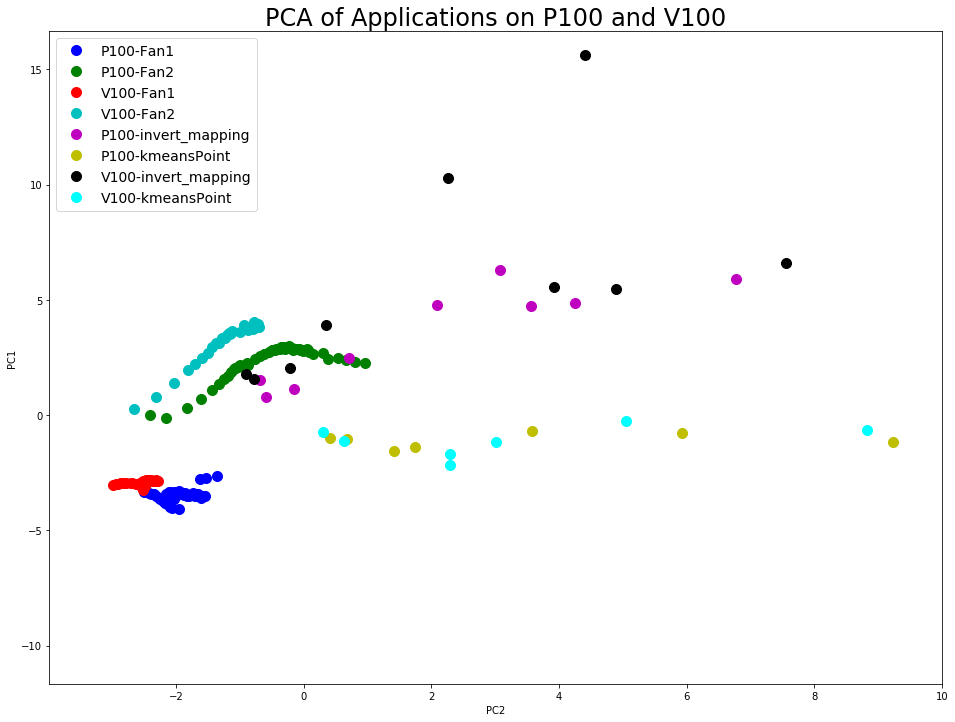

In [50]:
# print(__doc__)
####!!!! NEED TO DEBUG - can't convert string to flaot P100 !!!!!######
from time import time
import numpy as np
import matplotlib.pyplot as plt

from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.datasets import load_digits
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
%matplotlib inline

#np.random.seed(42)
labels = df['kernelname'].tolist()
archi = df['Architecture'].tolist()
#labels = df['Architecture'].tolist()
#when making tag, take concatenation of architecture
#v100_bool = [ av=="V100" for av in archi ]
#p100_bool = [ av=="P100" for av in archi ]
#print(n_samples, n_features)
df2 = df.drop(columns=['Architecture'])
df2 = df2.drop(columns=['kernelname'])
#print(df2.keys)
#print(df2)
df2_values = df2.values
#data = scale(df2_values)
#mask = np.any(np.isnan(df2) | np.equal(df2,0), axis=1)
#df2[~mask]
#print(df2)
#print(df2)
if True:
    #digits = load_digits()
    #data = scale(digits.data)
    data = scale(df2.values)
    
    n_samples, n_features = data.shape
    n_digits = len(target_kernels)
    """
    np.random.seed(42)

    digits = load_digits()
    data = scale(digits.data)

    n_samples, n_features = data.shape
    n_digits = len(np.unique(digits.target))
    labels = digits.target

    print("digits", digits)
    print("data", data)
    print("n_samples", n_samples)
    print("labels",labels)
    """

    sample_size = 300

    print("n_digits: %d, \t n_samples %d, \t n_features %d"
          % (n_digits, n_samples, n_features))


    print(82 * '_')
    print('init\t\ttime\tinertia\thomo\tcompl\tv-meas\tARI\tAMI\tsilhouette')


    def bench_k_means(estimator, name, data):
        t0 = time()
        estimator.fit(data)
        print('%-9s\t%.2fs\t%i\t%.3f\t%.3f\t%.3f\t%.3f\t%.3f\t%.3f'
              % (name, (time() - t0), estimator.inertia_,
                 metrics.homogeneity_score(labels, estimator.labels_),
                 metrics.completeness_score(labels, estimator.labels_),
                 metrics.v_measure_score(labels, estimator.labels_),
                 metrics.adjusted_rand_score(labels, estimator.labels_),
                 metrics.adjusted_mutual_info_score(labels,  estimator.labels_),
                 metrics.silhouette_score(data, estimator.labels_,
                                          metric='euclidean',
                                          sample_size=sample_size)))

    bench_k_means(KMeans(init='k-means++', n_clusters=n_digits, n_init=10),
                  name="k-means++", data=data)

    bench_k_means(KMeans(init='random', n_clusters=n_digits, n_init=10),
                  name="random", data=data)

    # in this case the seeding of the centers is deterministic, hence we run the
    # kmeans algorithm only once with n_init=1
    pca = PCA(n_components=n_digits).fit(data)
    bench_k_means(KMeans(init=pca.components_, n_clusters=n_digits, n_init=1),
                  name="PCA-based",
                  data=data)
    print(82 * '_')

    # #############################################################################
    # Visualize the results on PCA-reduced data

    reduced_data = PCA(n_components=2).fit_transform(data)
    kmeans = KMeans(init='k-means++', n_clusters=n_digits, n_init=10)
    kmeans.fit(reduced_data)

    # Step size of the mesh. Decrease to increase the quality of the VQ.
    h = .02     # point in the mesh [x_min, x_max]x[y_min, y_max].

    # Plot the decision boundary. For that, we will assign a color to each
    x_min, x_max = reduced_data[:, 0].min() - 1, reduced_data[:, 0].max() + 1
    y_min, y_max = reduced_data[:, 1].min() - 1, reduced_data[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

    # Obtain labels for each point in mesh. Use last trained model.
    Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])

    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    #plt.figure(1)
    plt.figure(figsize=(16,12))
    plt.clf()
    """
    plt.imshow(Z, interpolation='nearest',
               extent=(xx.min(), xx.max(), yy.min(), yy.max()),
               cmap=plt.cm.Paired,
               aspect='auto', origin='lower')

    plt.plot(reduced_data[:, 0], reduced_data[:, 1], 'k.', markersize=2)


    """
    plt.plot(reduced_data[:, 0], reduced_data[:, 1], 'k.',markersize=2)
    x =[]
    y =[]
    plot_dict = {}
    for i in range(len(labels)):
        tag = archi[i] + "-" + labels[i]
        if labels[i] == "kmeansPoint":
            print(tag)
        #tag = "P100-"
        """if v100_bool[i]:
            tag = "V100-"
        tag = tag+labels[i]""" 
        
        if tag in plot_dict:
            plot_dict[ tag ][0].append( reduced_data[i, 0] )
            plot_dict[ tag ][1].append( reduced_data[i, 1] )
        else:
            plot_dict[ tag ] = [ ]
            plot_dict[ tag ].append( [reduced_data[i, 0]] )
            plot_dict[ tag ].append( [reduced_data[i, 1]] )
            #'bo', 'go', 'ro', 'co', 'mo', 'yo', 'ko', 'wo',
    clr = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'aqua', 'aquamarine', 'azure', 'beige', 
           'bisque', 'black', 'blanchedalmond', 'blue', 'blueviolet', 'brown', 'burlywood', 'cadetblue', 'chartreuse', 'chocolate'
           , 'coral', 'cornflowerblue', 'cornsilk', 'crimson', 'cyan', 'darkblue', 'darkcyan', 'darkgoldenrod', 'darkgray', 
           'darkgreen', 'darkgrey', 'darkkhaki', 'darkmagenta', 'darkolivegreen', 'darkorange', 'darkorchid', 'darkred', 
           'darksalmon', 'darkseagreen', 'darkslateblue', 'darkslategray', 'darkslategrey', 'darkturquoise', 'darkviolet', 
           'deeppink', 'deepskyblue', 'dimgray', 'dimgrey', 'dodgerblue', 'firebrick', 'floralwhite', 'forestgreen', 'fuchsia', 
           'gainsboro', 'ghostwhite', 'gold', 'goldenrod', 'gray', 'green', 'greenyellow', 'grey', 'honeydew', 'hotpink', 
           'indianred', 'indigo', 'ivory', 'khaki', 'lavender', 'lavenderblush', 'lawngreen', 'lemonchiffon', 'lightblue',
           'lightcoral', 'lightcyan', 'lightgoldenrodyellow', 'lightgray', 'lightgreen', 'lightgrey', 'lightpink', 'lightsalmon', 'lightseagreen', 'lightskyblue', 'lightslategray', 'lightslategrey', 'lightsteelblue', 'lightyellow', 'lime', 'limegreen', 'linen', 'magenta', 'maroon', 'mediumaquamarine', 'mediumblue', 'mediumorchid', 'mediumpurple', 'mediumseagreen', 'mediumslateblue', 'mediumspringgreen', 'mediumturquoise', 'mediumvioletred', 'midnightblue',
           'mintcream', 'mistyrose', 'moccasin', 'navajowhite', 'navy', 'oldlace', 'olive', 'olivedrab', 'orange', 'orangered', 
           'orchid']
    
    #print(plot_dict)
    
    #clr = [ 'bo', 'ko', 'go', 'co', 'yo', 'ro', 'bx', 'kx', 'gx', 'cx', 'yx', 'rx']
    cind=0
    for k,v in plot_dict.items():
        plt.plot(v[0], v[1], color = clr[cind], label=k,  markersize=10, marker ='o', linestyle = 'None' )
        cind+=1

    """
    # Plot the centroids as a white X
    centroids = kmeans.cluster_centers_
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='x', s=169, linewidths=3,
                color='w', zorder=10)"""
    #plt.title('K-means clustering Application benchmarking data (PCA-reduced data)\n'
              #'Centroids are marked with white cross')
    plt.title("PCA of Applications on P100 and V100",fontsize=24 )
    plt.xlim(x_min, 10)
    plt.ylim(y_min, y_max)
    plt.ylabel("PC1")
    plt.xlabel("PC2")
    #plt.xticks(())
    #plt.yticks(())

    plt.legend(loc='best',prop={'size':14})
    plt.savefig("PCA_v100_p100.png")
    plt.show()

In [8]:
# Projecting the 118 dimensional space to a 2-d space where the data points belong to the targets.
#principal components of the features